In [36]:
import pandas as pd
data = pd.read_csv("./preprocessed_data.csv")

In [37]:
X = data.drop("project_is_approved",axis=1)
y = data['project_is_approved'].values

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(73196, 8) (73196,)
(36052, 8) (36052,)


In [39]:
import pickle
with open('./glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000,stop_words = 'english')
tfidf_model.fit(X_train['essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [41]:
#For tdidf_weighted w2v for train Data
from tqdm import tqdm
import numpy as np
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|██████████| 73196/73196 [01:23<00:00, 876.25it/s]

73196
300


In [42]:
#for X_test data
from tqdm import tqdm
import numpy as np
tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|██████████| 36052/36052 [00:41<00:00, 874.40it/s]

36052
300


In [43]:
from sklearn.feature_extraction.text import CountVectorizer
#school state
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

In [44]:
#teacher prefix
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)

X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

In [45]:
#project grade catagory
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)

X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

In [46]:
#Normalizing Price Data
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))

X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

In [47]:
#clean subcatagories
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subcat_ohe = vectorizer.transform(X_train['clean_subcategories'].values)

X_test_subcat_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

In [48]:
#clean catagories
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_cat_ohe = vectorizer.transform(X_train['clean_categories'].values)

X_test_cat_ohe = vectorizer.transform(X_test['clean_categories'].values) 

In [49]:
#teacher_number_of_previously_posted_projects
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_prev_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_test_prev_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

In [50]:
#sentiment scores
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sentiment_scores = []
for sentence in tqdm(X_train['essay'].values):
  dic = sid.polarity_scores(sentence)
  comp = dic['compound']
  neg = dic['neg']
  neu = dic['neu']
  pos = dic['pos']
  sentiment_scores.append([comp,neg,neu,pos])

sentiment_score_test = []
for sentence in tqdm(X_test['essay'].values):
  dic = sid.polarity_scores(sentence)
  comp = dic['compound']
  neg = dic['neg']
  neu = dic['neu']
  pos = dic['pos']
  sentiment_score_test.append([comp,neg,neu,pos])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [53]:
from scipy.sparse import hstack
X_tr = hstack((tfidf_w2v_vectors, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_norm,X_train_cat_ohe, X_train_subcat_ohe,X_train_prev_norm,sentiment_scores)).tocsr()

X_te = hstack((tfidf_w2v_vectors_test, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm,X_test_cat_ohe ,X_test_subcat_ohe,X_test_prev_norm,sentiment_score_test)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)

print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(73196, 405) (73196,)
(36052, 405) (36052,)


# **Applying Decision Tree on TFIDF weighted W2V**

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
model = DecisionTreeClassifier()
params = {'max_depth':[1,5,10,50],'min_samples_split':[5,10,100,500]}
grid_search = GridSearchCV(model,params,'roc_auc',return_train_score=True,n_jobs=-1)
grid_search.fit(X_tr,y_train)

D:\conda\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning:

Pass scoring=roc_auc as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error



GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [55]:
grid_search.best_params_

{'max_depth': 5, 'min_samples_split': 5}

In [56]:
grid_search.cv_results_

{'mean_fit_time': array([ 11.88432398,  11.97321644,  11.83836217,   7.05129457,
         24.71215339,  24.31754975,  23.77980494,  23.75811729,
         65.84346886,  65.78126612,  61.81570039,  50.88832912,
        292.88594704, 287.17534213, 246.53852248, 101.67776618]),
 'std_fit_time': array([ 0.15924402,  0.15067846,  0.23853738,  2.30141712,  1.43661912,
         0.93187431,  0.7918269 ,  0.94762172,  3.08422926,  2.48851122,
         1.09432232,  1.40001532,  7.40379887, 10.32462   ,  4.64023859,
        21.24196671]),
 'mean_score_time': array([0.12947888, 0.12644877, 0.12714481, 0.07341256, 0.07771702,
        0.09098139, 0.08463693, 0.06101336, 0.05936246, 0.06927423,
        0.06321554, 0.05785728, 0.04846225, 0.04189792, 0.04973102,
        0.03396158]),
 'std_score_time': array([0.04524823, 0.02221448, 0.04942148, 0.01942964, 0.01488188,
        0.03101629, 0.03271972, 0.0105647 , 0.00438103, 0.01023069,
        0.00945407, 0.00404211, 0.01180564, 0.01452719, 0.01164342,


In [57]:
points_for_plot_train = []
points_for_plot_test = []
points_for_plot = []

for param in grid_search.cv_results_['params']:
  max_depth = param['max_depth']
  min_samples_split = param['min_samples_split']
  lis = [max_depth,min_samples_split]
  points_for_plot.append(lis)


mean_test_score = grid_search.cv_results_['mean_test_score']

mean_train_score = grid_search.cv_results_['mean_train_score']

points_for_plot_train = points_for_plot[:]
points_for_plot_test = points_for_plot[:]


i = 0
for point in points_for_plot_train:
  point.append(mean_train_score[i])
  i = i+1


i = 0
for point in points_for_plot_test:
  point.append(mean_test_score[i])
  i = i+1


points_for_plot_train = np.array(points_for_plot_train)
points_for_plot_test = np.array(points_for_plot_test)

In [58]:
import matplotlib.pyplot as plt
import plotly.graph_objs as go

x1 = points_for_plot_train[:,0]
y1 = points_for_plot_train[:,1]
z1 = points_for_plot_train[:,2]

x2 = points_for_plot_test[:,0]
y2 = points_for_plot_test[:,1]
z2 = points_for_plot_test[:,3]

trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='max_depth'),
        yaxis = dict(title='min_sample_split'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
fig.show()
plt.show()

In [59]:
best_model = DecisionTreeClassifier(max_depth = 5, min_samples_split = 500,)
best_model.fit(X_tr,y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=500)

In [60]:
best_model.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.0479    ,
       0.        , 0.16464843, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01490678, 0.        , 0.00929568, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02442882, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02031977, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02861145, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [61]:
y_train_predicted = best_model.predict_proba(X_tr)
y_test_predicted = best_model.predict_proba(X_te)
y_train_predicted
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_train,y_train_predicted[:,1])
auc_score
#roc on train and test
from sklearn.metrics import roc_curve
train_fpr,train_tpr,_ = roc_curve(y_train,y_train_predicted[:,1])
plt.plot(train_fpr,train_tpr,label='train_roc')
test_fpr,test_tpr,_ = roc_curve(y_test,y_test_predicted[:,1])
plt.plot(test_fpr,test_tpr,label='test_roc')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [65]:
from sklearn.metrics import confusion_matrix
y_test_predicted = best_model.predict(X_te)
confusion_matrix = confusion_matrix(y_test,y_test_predicted)

from mlxtend.plotting import plot_confusion_matrix
 
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

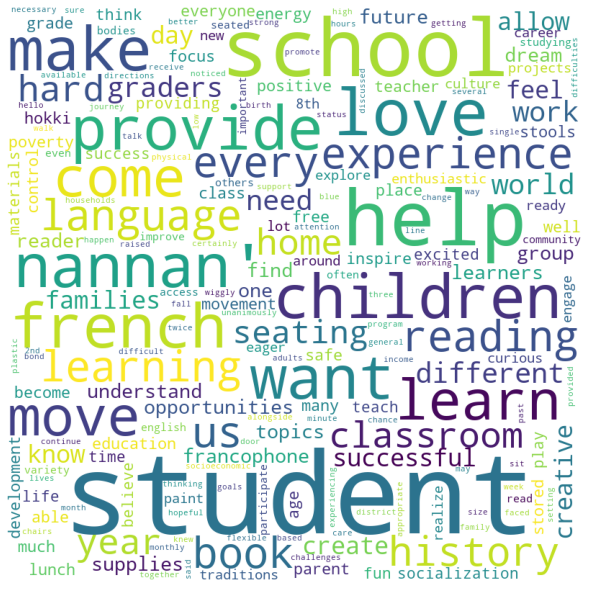

In [67]:
#word cloud
lis_false_pos = []
for p in range(len(y_test_predicted)):
  if (y_test[p]==0)& (y_test_predicted[p] ==1):
    lis_false_pos.append(p)
essays = (X_test["essay"].iloc[lis_false_pos]).values
essays = str(essays)

from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
comment_words = X_test["essay"]
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(essays)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

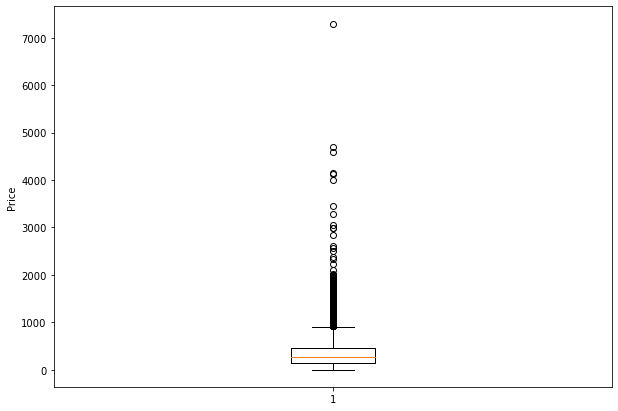

In [68]:
#box plot
prices = (X_test["price"].iloc[lis_false_pos]).values
plt.figure(figsize =(10, 7))
plt.boxplot(prices)
plt.ylabel("Price")
plt.show()

D:\conda\envs\tf_gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



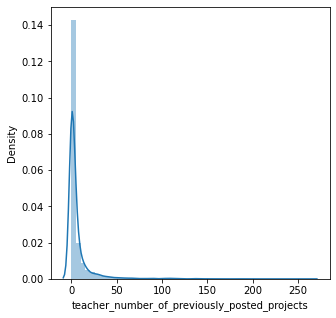

In [69]:
import seaborn as sns
prev = (X_test["teacher_number_of_previously_posted_projects"].iloc[lis_false_pos]).values
plt.figure(figsize =(5, 5))
sns.distplot(prev)
plt.xlabel("teacher_number_of_previously_posted_projects")
plt.show()

In [1]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper Parameter", "Auc"]
x.add_row(["TFIDF-W2V","Decision Tree",grid_search.best_params_,str(grid_search.best_score_)])
print(x)

NameError: name 'grid_search' is not defined